In [174]:
# Main source : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [175]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [176]:
# Custom Dataset to manage images (28x28) and their labels. Mainly related to the Dead Sea Scrolls.
class CustomDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.load_images(images_file)
        self.labels = self.load_labels(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def load_images(self, file_path):
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)  # Skip first 16 bytes
        num_images = len(data) // (28 * 28)
        data = data.reshape(num_images, 28, 28)
        return data.copy()  # Ensure the array is writable

    def load_labels(self, file_path):
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=8)  # Skip first 8 bytes
        return data

In [177]:
train_images_file = "dataset/train-images-idx3-ubyte"
train_labels_file = "dataset/train-labels-idx1-ubyte"
validation_images_file = "dataset/validation-images-idx3-ubyte"
validation_labels_file = "dataset/validation-labels-idx1-ubyte"

batch_size = 6 # number of samples (images and their corresponding labels) to be loaded and processed together for each iteration of training or model validation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_set = CustomDataset(train_images_file, train_labels_file, transform=transform) # Loading Dataset Training
validation_set = CustomDataset(validation_images_file, validation_labels_file, transform=transform) # Loading Dataset Validation

validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True) # Shuffle Dataset Validation and divide into batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # Shuffle Dataset Training and divide into batches

'''
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
validation_set = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
'''

"\ntrain_set = torchvision.datasets.MNIST(root='./data', train=True,\n                                        download=True, transform=transform)\nvalidation_set = torchvision.datasets.MNIST(root='./data', train=False,\n                                        download=True, transform=transform)\n\nvalidation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,\n                                         shuffle=False, num_workers=2)\ntrain_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,\n                                          shuffle=True, num_workers=2)\n"

In [178]:
# Generate Dictionnary of Hebrew Characters to correspond to the labels (0 to 21)
with open('dictionnary_labels.txt', 'r') as file:
    lines = file.readlines()

map_dict = {}

for line in lines:
    line = line.strip()
    key, value = line.split('_')
    map_dict[int(key) - 1] = value

print(map_dict[0])

"""
map_dict = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
print(map_dict[0])
"""

Alef


'\nmap_dict = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}\nprint(map_dict[0])\n'

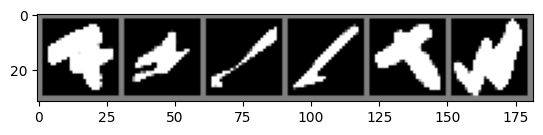

Yod   Yod   Lamed Lamed Tav   Shin 


In [179]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{map_dict[int(labels[j])]:5s}' for j in range(batch_size)))

In [180]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer: input channels = 1 (dimension of the picture), output channels = 6, kernel size = 5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Max pooling layer: kernel size = 2x2, stride = 2
        self.pool = nn.MaxPool2d(2, 2)
         # Second convolutional layer: input channels = 6, output channels = 16, kernel size = 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # First fully connected layer: input features = 16*4*4, output features = 120
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        # Second fully connected layer: input features = 120, output features = 84
        self.fc2 = nn.Linear(120, 84)
        # Output layer: input features = 84, output features = 22 (assuming 22 classes)
        self.fc3 = nn.Linear(84, 22)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
# Instantiate the neural network
net = Net()

In [181]:
import torch.optim as optim

# Define a Loss function and optimizer :

# Define the loss function
criterion = nn.CrossEntropyLoss()
'''
- `nn.CrossEntropyLoss()`: This creates an instance of the Cross Entropy Loss criterion.
  Cross Entropy Loss is commonly used for classification problems. It computes the 
  cross-entropy loss between the predicted probability distribution and the true 
  label distribution. It is suitable for multi-class classification tasks.
'''

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
'''
- `optim.SGD()`: This creates an instance of the Stochastic Gradient Descent (SGD) optimizer.
  Stochastic Gradient Descent is a popular optimization algorithm used for training 
  neural networks. It updates the parameters (weights and biases) of the network 
  based on the gradients of the loss function with respect to those parameters.
- `net.parameters()`: This specifies the parameters (weights and biases) of the neural 
  network that should be optimized.
- `lr=0.001`: This sets the learning rate, which controls the step size of the parameter 
  updates during optimization. A learning rate of 0.001 is commonly used as a starting 
  point for many optimization tasks.
- `momentum=0.9`: This sets the momentum parameter, which accelerates SGD in the 
  relevant direction and dampens oscillations. It helps to converge faster towards 
  the minimum of the loss function.
'''

'\n- `optim.SGD()`: This creates an instance of the Stochastic Gradient Descent (SGD) optimizer.\n  Stochastic Gradient Descent is a popular optimization algorithm used for training \n  neural networks. It updates the parameters (weights and biases) of the network \n  based on the gradients of the loss function with respect to those parameters.\n- `net.parameters()`: This specifies the parameters (weights and biases) of the neural \n  network that should be optimized.\n- `lr=0.001`: This sets the learning rate, which controls the step size of the parameter \n  updates during optimization. A learning rate of 0.001 is commonly used as a starting \n  point for many optimization tasks.\n- `momentum=0.9`: This sets the momentum parameter, which accelerates SGD in the \n  relevant direction and dampens oscillations. It helps to converge faster towards \n  the minimum of the loss function.\n'

In [194]:
"""
4 Mesures to understand the training model :

-- Loss -- 

Loss is a measure of model error. It quantifies the extent to which the model's predictions deviate from the true values.
Cross-Entropy Loss computes the difference between two probability distributions for a provided set of occurrences or random variables.
The loss is between 0 (good) and 1 (bad).

Other loss functions : https://neptune.ai/blog/pytorch-loss-functions

-- Accuracy --

Accuracy is the percentage of correct predictions out of all predictions. 
It is calculated as the number of correct predictions divided by the total number of predictions.
The Accuracy is between 0 (bad) and 1 (good).

-- Recall --

Recall is the percentage of true positives captured among all the elements that are actually positive. 
It is calculated as the number of true positives divided by the sum of true positives and false negatives.
The Recall is between 0 (bad) and 1 (good).

-- F1-score --

The F1-score is the harmonic mean of precision and recall. 
It is calculated as F1 = 2 * ((Accuracy*Recall)/(Accuracy+Recall))

"""

"\n4 Mesures to understand the training model :\n\n-- Loss -- \n\nLoss is a measure of model error. It quantifies the extent to which the model's predictions deviate from the true values.\nCross-Entropy Loss computes the difference between two probability distributions for a provided set of occurrences or random variables.\nThe loss is between 0 (good) and 1 (bad).\n\nOther loss functions : https://neptune.ai/blog/pytorch-loss-functions\n\n-- Accuracy --\n\nAccuracy is the percentage of correct predictions out of all predictions. \nIt is calculated as the number of correct predictions divided by the total number of predictions.\nThe Accuracy is between 0 (bad) and 1 (good).\n\n-- Recall --\n\nRecall is the percentage of true positives captured among all the elements that are actually positive. \nIt is calculated as the number of true positives divided by the sum of true positives and false negatives.\nThe Recall is between 0 (bad) and 1 (good).\n\n-- F1-score --\n\nThe F1-score is the 

In [182]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

for epoch in range(150):  # loop over the dataset multiple times

    running_loss = 0.0
    all_labels = []
    all_preds = []
    num_mini_batches = len(train_loader)
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # collect predictions and true labels
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # print statistics
        running_loss += loss.item()
        """
        if i % 11 == 0:    # print every 2 mini-batches for this example
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0
        """    

    # Calculate metrics for the current epoch
    average_loss = running_loss / num_mini_batches
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f'Epoch [{epoch + 1}] Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}, loss: {average_loss:.3f}')

print('Finished Training')

PATH = './PNA_net.pth'
torch.save(net.state_dict(), PATH)

C:\Users\leo22\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1] Accuracy: 0.324, Recall: 0.244, F1-score: 0.247, loss: 1.878
Epoch [2] Accuracy: 0.693, Recall: 0.690, F1-score: 0.683, loss: 0.874
Epoch [3] Accuracy: 0.788, Recall: 0.789, F1-score: 0.788, loss: 0.624
Epoch [4] Accuracy: 0.847, Recall: 0.847, F1-score: 0.847, loss: 0.455
Epoch [5] Accuracy: 0.887, Recall: 0.887, F1-score: 0.887, loss: 0.340
Epoch [6] Accuracy: 0.905, Recall: 0.905, F1-score: 0.905, loss: 0.281
Epoch [7] Accuracy: 0.923, Recall: 0.923, F1-score: 0.923, loss: 0.220
Epoch [8] Accuracy: 0.936, Recall: 0.936, F1-score: 0.936, loss: 0.178
Epoch [9] Accuracy: 0.947, Recall: 0.948, F1-score: 0.947, loss: 0.155
Epoch [10] Accuracy: 0.953, Recall: 0.953, F1-score: 0.953, loss: 0.128
Epoch [11] Accuracy: 0.962, Recall: 0.962, F1-score: 0.962, loss: 0.107
Epoch [12] Accuracy: 0.964, Recall: 0.964, F1-score: 0.964, loss: 0.094
Epoch [13] Accuracy: 0.976, Recall: 0.976, F1-score: 0.976, loss: 0.071
Epoch [14] Accuracy: 0.982, Recall: 0.982, F1-score: 0.982, loss: 0.054
E

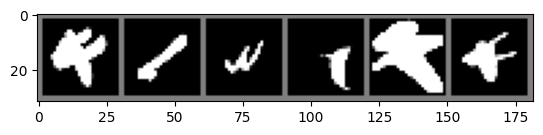

Alef  Lamed Shin  Yod   Waw   Alef 


In [183]:
# get some random validation images
dataiter = iter(validation_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{map_dict[int(labels[j])]:5s}' for j in range(batch_size)))

In [184]:
net = Net()
net.load_state_dict(torch.load(PATH)) #Saving the model into a file

<All keys matched successfully>

In [185]:
outputs = net(images)

In [186]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{map_dict[int(predicted[j])]:5s}'
                              for j in range(batch_size)))

Predicted:  Alef  Lamed Shin  Yod   Waw   Alef 


In [187]:
def predict_solution(outputs, batch_size, topk) : # outputs results, batch size and the top n of probabilities
    # Rescales them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.
    probabilities = F.softmax(outputs, dim=1)

    # Retrieve the top 3 predictions for each image
    top_probs, top_labels = torch.topk(probabilities, topk, dim=1)

    # Mapping labels to classes
    predictions = []
    for i in range(batch_size):
        predictions.append([(map_dict[int(top_labels[i][j])], top_probs[i][j].item()) for j in range(topk)])

    # Display predictions
    for i, preds in enumerate(predictions):
        print(f'Image {i+1}:')
        for label, prob in preds:
            print(f'  {label}: {prob*100:.2f}%')

In [188]:
predict_solution(outputs, batch_size, 5);

Image 1:
  Alef: 100.00%
  Tav: 0.00%
  Waw: 0.00%
  Yod: 0.00%
  Shin: 0.00%
Image 2:
  Lamed: 100.00%
  Tav: 0.00%
  Shin: 0.00%
  Waw: 0.00%
  Yod: 0.00%
Image 3:
  Shin: 100.00%
  Yod: 0.00%
  Tav: 0.00%
  Lamed: 0.00%
  Hey: 0.00%
Image 4:
  Yod: 99.96%
  Tav: 0.03%
  Waw: 0.01%
  Hey: 0.00%
  Lamed: 0.00%
Image 5:
  Waw: 100.00%
  Hey: 0.00%
  Yod: 0.00%
  Alef: 0.00%
  Tav: 0.00%
Image 6:
  Alef: 100.00%
  Tav: 0.00%
  Hey: 0.00%
  Shin: 0.00%
  Yod: 0.00%


In [189]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

image = Image.open("test_image_1.jpg") #Loading Image to test with the model
image = ImageOps.invert(image.convert('L')) #Putting into a greyscale
image = transform(image)
image = image.unsqueeze(0)

outputs2 = net(image) #Test with model

predict_solution(outputs2, 1, 5) #Results

image = Image.open("test_image_2.jpg") #Loading Image to test with the model
image = ImageOps.invert(image.convert('L')) #Putting into a greyscale
image = transform(image)
image = image.unsqueeze(0)

outputs2 = net(image) #Test with model

predict_solution(outputs2, 1, 5) #Results

Image 1:
  Hey: 100.00%
  Yod: 0.00%
  Waw: 0.00%
  Alef: 0.00%
  Resh: 0.00%
Image 1:
  Yod: 100.00%
  Shin: 0.00%
  Alef: 0.00%
  Hey: 0.00%
  Waw: 0.00%


In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)  # Envoyer les images sur le GPU si disponible
            targets = targets.to(device)  # Envoyer les étiquettes sur le GPU si disponible

            # Faire des prédictions
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Sélectionner la classe avec la plus haute probabilité

            # Collecter les prédictions et les étiquettes réelles
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Exemple d'utilisation
predictions, targets = evaluate_model(net, validation_loader)

In [191]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
current_labels_num = list(dict.fromkeys(targets))
current_labels_num.sort()
#doc : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
conf_matrix = confusion_matrix(targets, predictions)

# Afficher la matrice de confusion (optionnel)
print(conf_matrix)

[[163   0   1   3   0   0   3]
 [  0 160   1   7   0   0   0]
 [  3   2 168   1   0   0   0]
 [  1   5   1 177   0   0   0]
 [  0   0   0   0 187   0   0]
 [  0   0   0   3   1 121   0]
 [  5   0   2   1   0   2 145]]


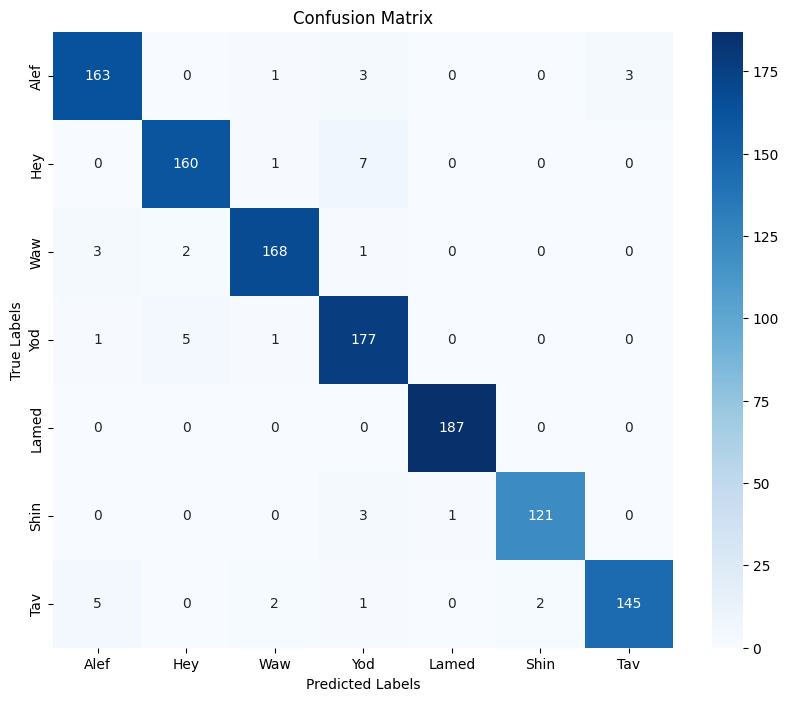

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définir les noms de classe (étiquettes)
current_labels_num = list(dict.fromkeys(targets))
current_labels_num.sort()
output_list = [map_dict.get(label, 'unknown') for label in current_labels_num]
classes = output_list

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()